### Необходимык библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Colab Notebooks/Диплом
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Диплом
NPS_embed.ipynb  NSews_emb.ipynb  preprocess_recall.xlsx  комментарии_банки.xlsx


### Подготавливаем данные

In [65]:
comments_raw_data = pd.read_excel('комментарии_банки.xlsx')

In [66]:
comments_raw_data['datePublished'] = pd.to_datetime(comments_raw_data['datePublished'])
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])

In [67]:
comments_raw_data

,bank,author,datePublished,description,name,rating
0,vwbank,Bayazitof,2022-03-25 20:01:53,"Брал автокредит в этом году, сам банк был райф...","Брали автокредит, смутила оценка",4.0
1,vwbank,user-90277016293,2022-01-26 12:23:32,Возникла проблема по кредитному договору. Трет...,Отсутствие связи с банком,1.0
2,vwbank,UserBox,2022-01-21 01:46:04,"Сказать, что возмущен - не сказать ничего. Вир...",Передают некорректную информацию в БКИ,1.0
3,vwbank,Sony Ericsson,2021-11-18 18:25:53,16.09.2021 оформил кредит. Номер договора 03**...,Досрочное погашение,1.0
4,vwbank,shulgaiv,2021-09-14 21:49:55,26.08.2021г. с ООО «Фольксваген Банк РУС» закл...,Нарушение банком условий кредитования,1.0
...,...,...,...,...,...,...
234654,alfabank,v.lan,2020-04-06 21:46:19,22 января 2020 года решил заказать себе Альфа ...,Создание максимума сложностей на пустом месте,2.0
234655,alfabank,Nut7,2020-04-06 19:36:25,Добрый день!В 2008 году мы с супругом взяли ип...,Справка о ссудной задолженности,1.0
234656,alfabank,user3998572,2020-04-06 18:05:21,Спустя 2 месяца пользования кредитной картой ...,Подключение страховки через смс без согласия,1.0
234657,alfabank,Наталья202,2020-04-06 12:55:31,Здравствуйте. Оставила заявку на сайте Альфа-б...,Претензия,1.0


### Статистики

Text(0.5, 1.0, 'Кол-во статей с отзывов c 2019 по 2023')

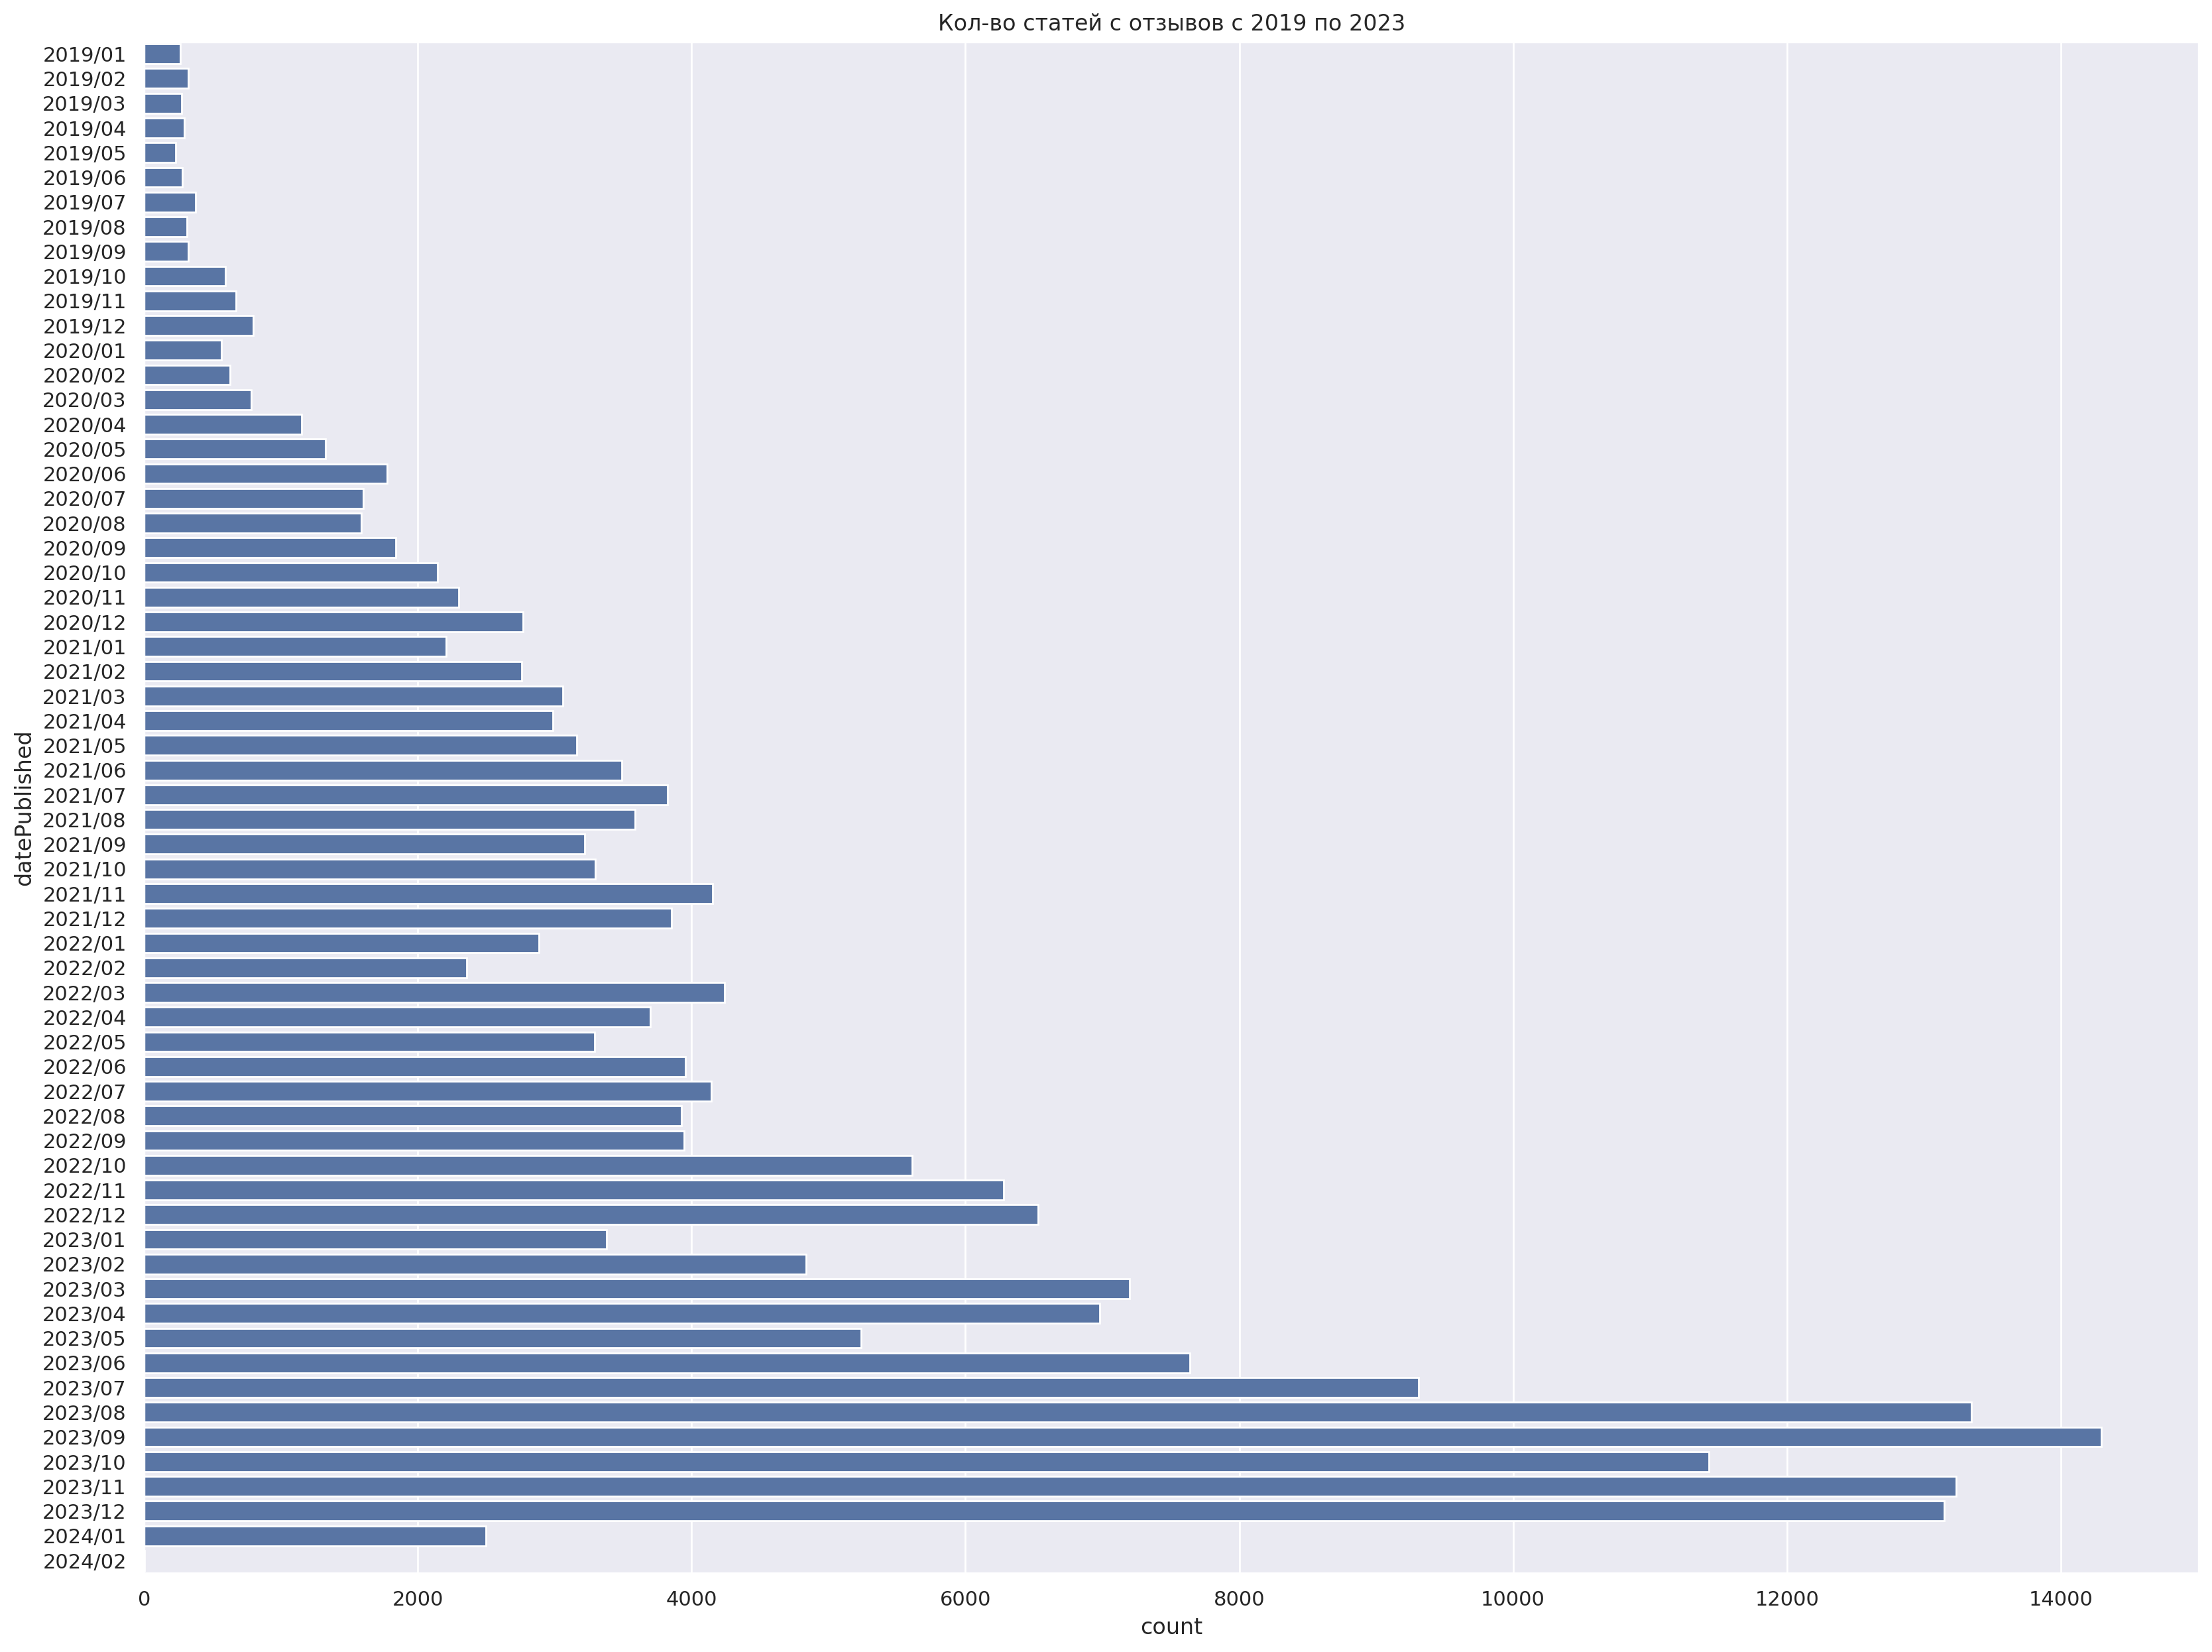

In [7]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.countplot(comments_raw_data[comments_raw_data['datePublished'].dt.year >= 2019]['datePublished'].dt.strftime('%Y/%m').sort_values()).set_title(f'Кол-во статей с отзывов c {2019} по {2023}')

In [8]:
comments_raw_data[comments_raw_data['datePublished'].dt.year >= 2019]['datePublished'].dt.strftime('%Y/%m').sort_values()

121423    2019/01
191319    2019/01
191318    2019/01
191317    2019/01
191316    2019/01
           ...   
193598    2024/01
193608    2024/01
75616     2024/02
75617     2024/02
57091     2024/02
Name: datePublished, Length: 226214, dtype: object

In [9]:
bank_counts = np.unique(comments_raw_data['bank'], return_counts=True)
popularity = sorted(list(zip(bank_counts[0], bank_counts[1])), key=lambda x:x[1], reverse=True)

names = [x[0] for x in popularity]
counts = [x[1] for x in popularity]

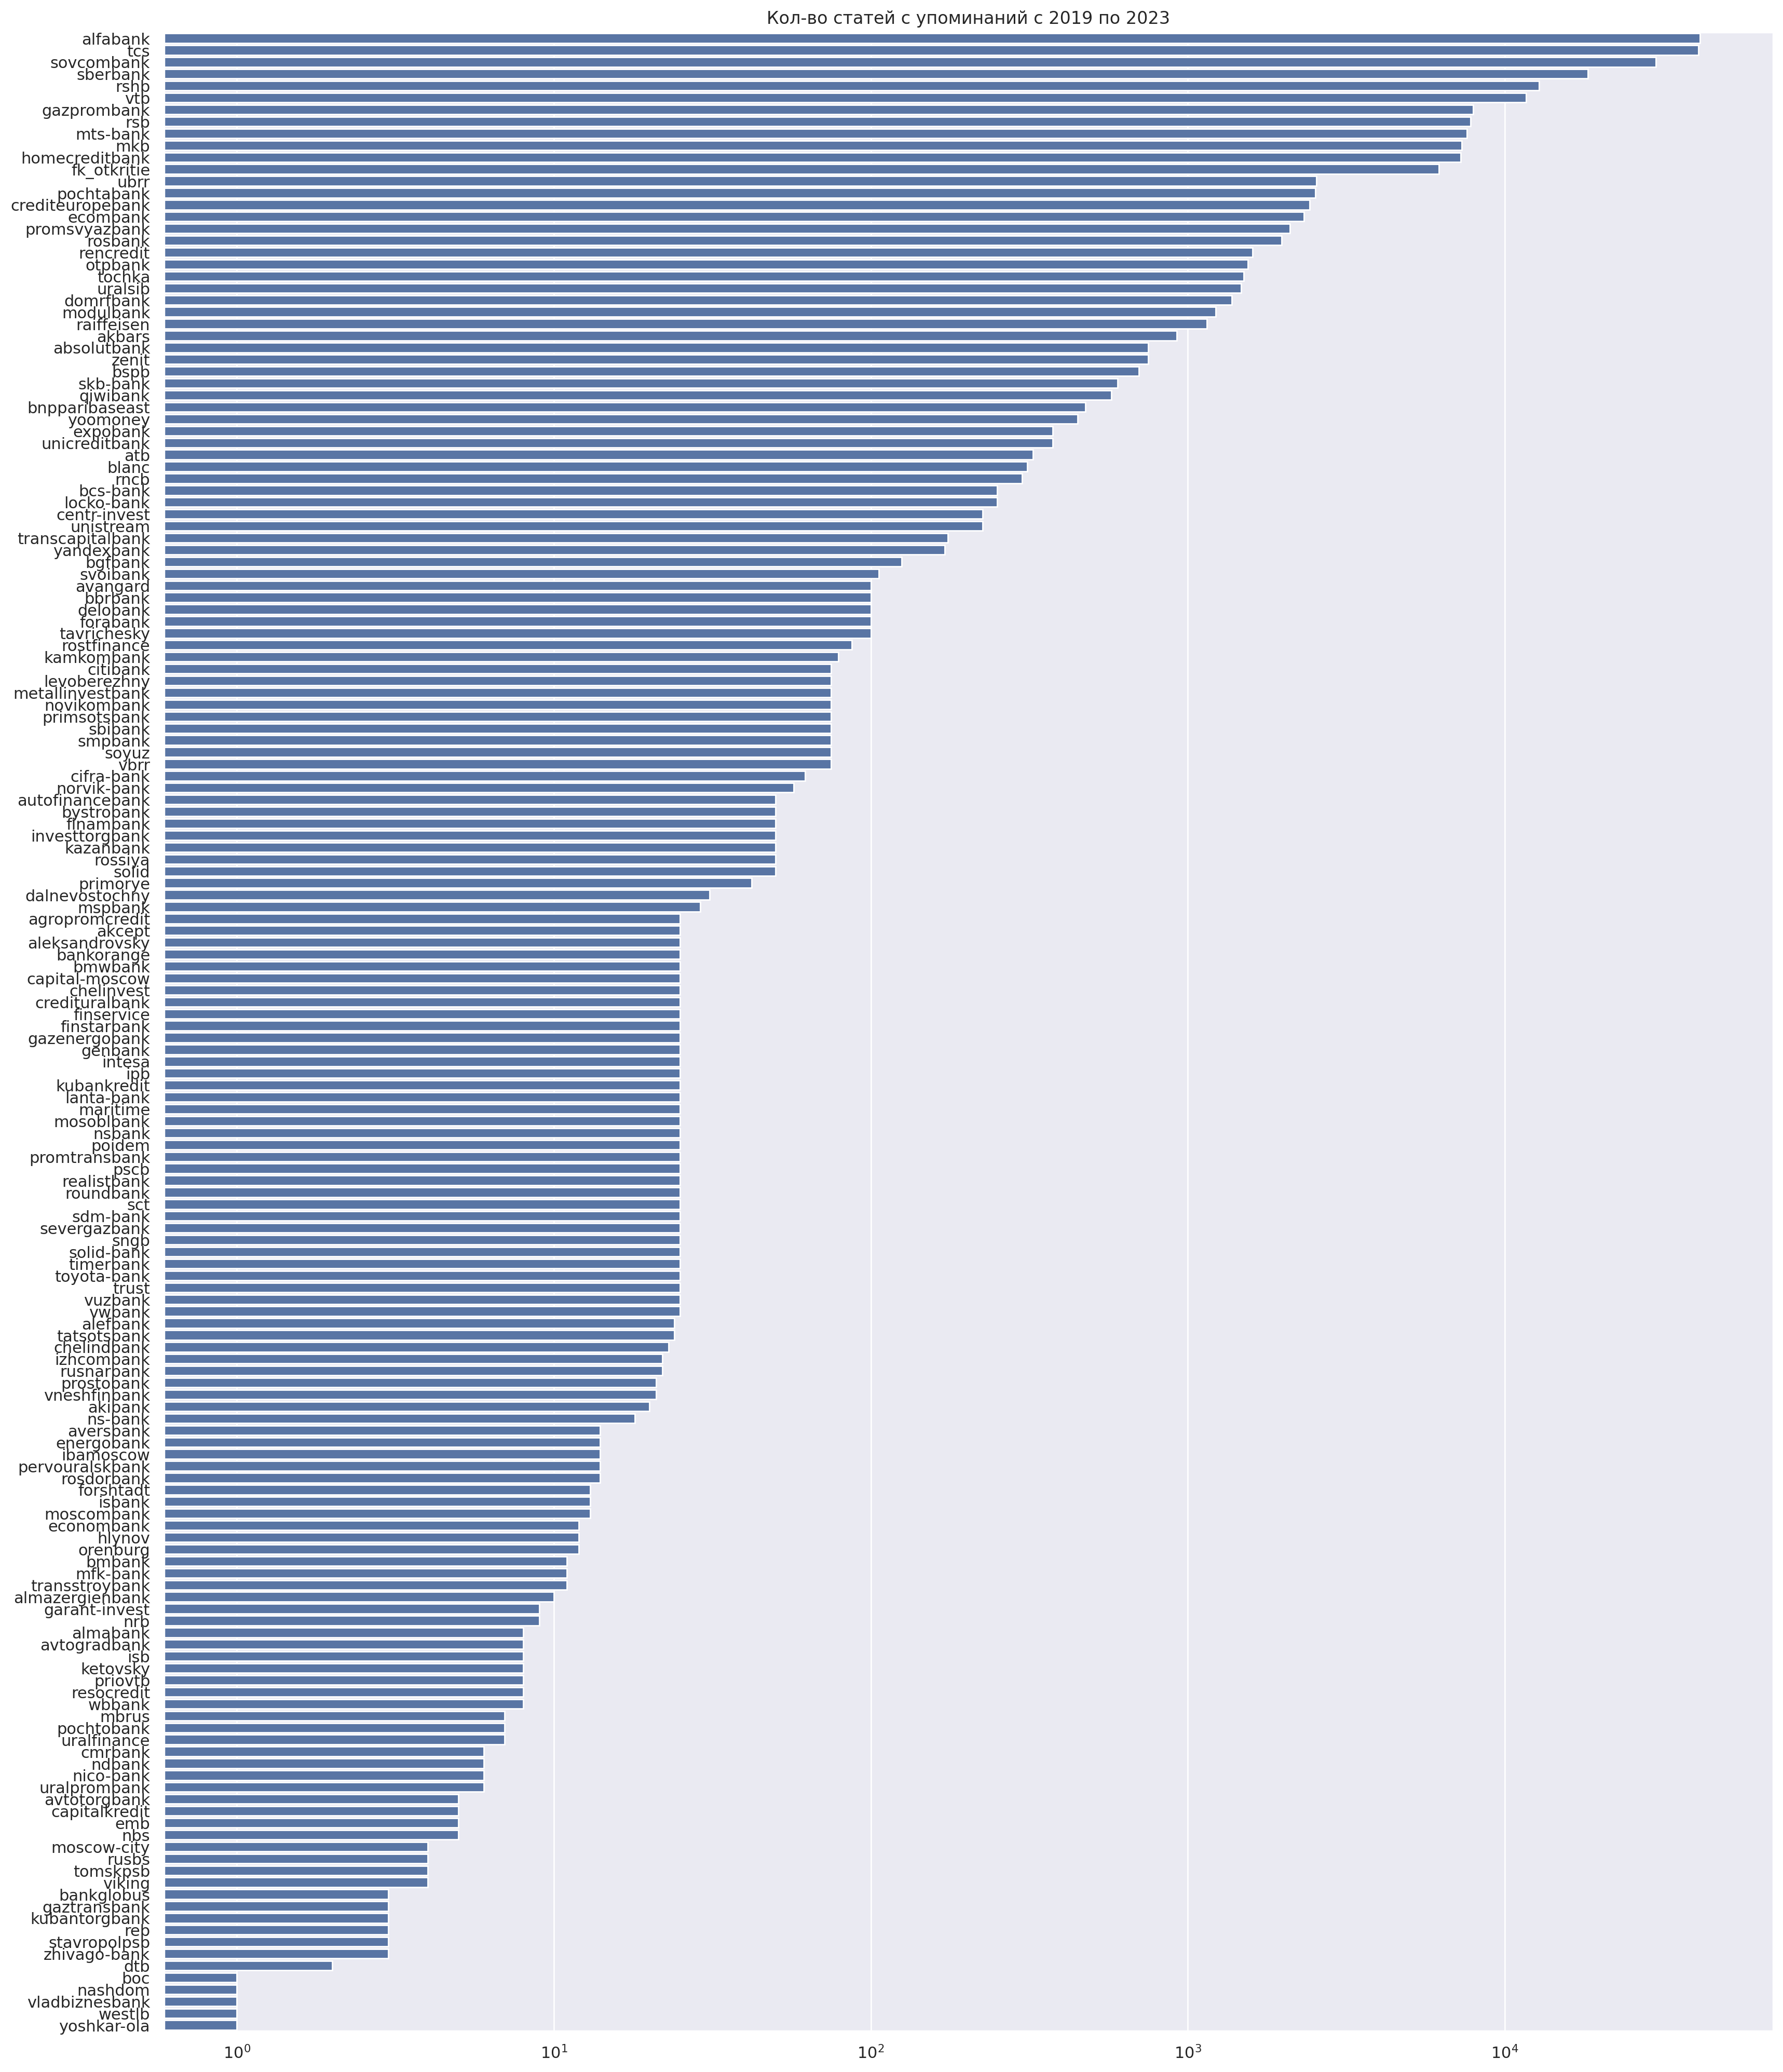

In [10]:
sns.set(rc={'figure.figsize':(20, 25)})

sns.barplot(x=counts, y=names).set_title(f'Кол-во статей с упоминаний c {2019} по {2023}')
plt.xscale('log')

In [4]:
from wordcloud import WordCloud

def draw_cloud(data):
    wc = WordCloud(background_color='white', max_words=1000,
                   width=1000, height=500)
    texts = data.astype(str)
    joint_text = ' '.join(list(texts))
    wc.generate(joint_text)
    return wc.to_image()

### Обработка текстов

In [12]:
data = comments_raw_data[['bank', 'description']]

In [22]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
tqdm.pandas()


mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [14]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)
    return text

In [17]:
data['description'] = data['description'].progress_apply(lambda x: preprocess_text(str(x)))

100%|██████████| 234659/234659 [43:53<00:00, 89.12it/s]
<ipython-input-17-a3f09ca0d178>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['description'] = data['description'].progress_apply(lambda x: preprocess_text(str(x)))


In [23]:
data['description'] = data['description'].progress_apply(lambda x: x.replace('qt', '').replace('lt', '').replace('quot', '').replace('gt', '').replace('p', '').replace('br', '').replace('li', ''))

100%|██████████| 234659/234659 [00:02<00:00, 92586.28it/s] 


In [30]:
data.to_excel('preprocess_recall.xlsx')

### Получение embeddings

In [5]:
data = pd.read_excel('preprocess_recall.xlsx')

In [6]:
data = data.drop(columns=['Unnamed: 0'])

In [7]:
data

,bank,description
0,vwbank,брать автокредит год банк райф счет немой весь...
1,vwbank,возникать проблема кредитный договор третий де...
2,vwbank,сказать возмущенный сказать ничто виртуальный ...
3,vwbank,16.09 2021 оформлять кредит номер договор 03 *...
4,vwbank,26.08 2021г ооо « фольксваген банк русый » з...
...,...,...
234654,alfabank,22 январь 2020 год решать заказывать альфа кар...
234655,alfabank,добрый день 2008 год супруг взять ипотечный кр...
234656,alfabank,спустя 2 месяц пользование кредитный карта 100...
234657,alfabank,здравствовать оставлять заявка сайт альфа-банк...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3)
tfidf.fit(data['description'])

TfidfVectorizer(min_df=3)

In [12]:
bank_vectors = pd.DataFrame(columns=[x for x in range(len(tfidf.vocabulary_))])
for bank in tqdm(np.unique(data['bank'])):
    sen = np.mean(tfidf.transform(data[data['bank'] == bank]['description']), axis=0)
    vec = pd.DataFrame(sen)
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

100%|██████████| 168/168 [00:33<00:00,  5.06it/s]


In [13]:
bank_vectors = bank_vectors.to_numpy()

In [14]:
from sklearn.cluster import SpectralClustering

spectr = SpectralClustering(n_clusters=2)
spectr.fit(bank_vectors)
labels = spectr.labels_

In [15]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})
clusster_data['spectr_clusters'] = spectr.labels_

In [16]:
data = data.merge(clusster_data, how='left', on='bank')

### Embeddings

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel

In [9]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [10]:
def embed_bert_cls(text, model=model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [22]:
bank_vectors = pd.DataFrame(columns=[x for x in range(312)])
for bank in np.unique(data['bank']):
    bank_embeds = pd.DataFrame(columns=[x for x in range(312)])
    bank_text_data = data[data['bank'] == bank]['description']
    for text in tqdm(bank_text_data):
        bank_embeds = pd.concat([bank_embeds, pd.DataFrame(embed_bert_cls(text).reshape(1,-1))], axis=0)
    sen = np.mean(bank_embeds.to_numpy(), axis=0)
    vec = pd.DataFrame(sen.reshape(1,-1))
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

100%|██████████| 3/3 [00:00<00:00, 201.74it/s]


In [34]:
from sklearn.cluster import SpectralClustering

spectr = SpectralClustering(n_clusters=4)
spectr.fit(bank_vectors)

SpectralClustering(n_clusters=4)

In [35]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})
clusster_data['bert_clusters'] = spectr.labels_

In [73]:
cl0 = clusster_data[clusster_data['bert_clusters'] == 0]['bank']
cl1 = clusster_data[clusster_data['bert_clusters'] == 1]['bank']
cl2 = clusster_data[clusster_data['bert_clusters'] == 2]['bank']
cl3 = clusster_data[clusster_data['bert_clusters'] == 3]['bank']

In [42]:
data_cl = data.copy()
data_cl = data_cl.merge(clusster_data, how='left', on='bank')

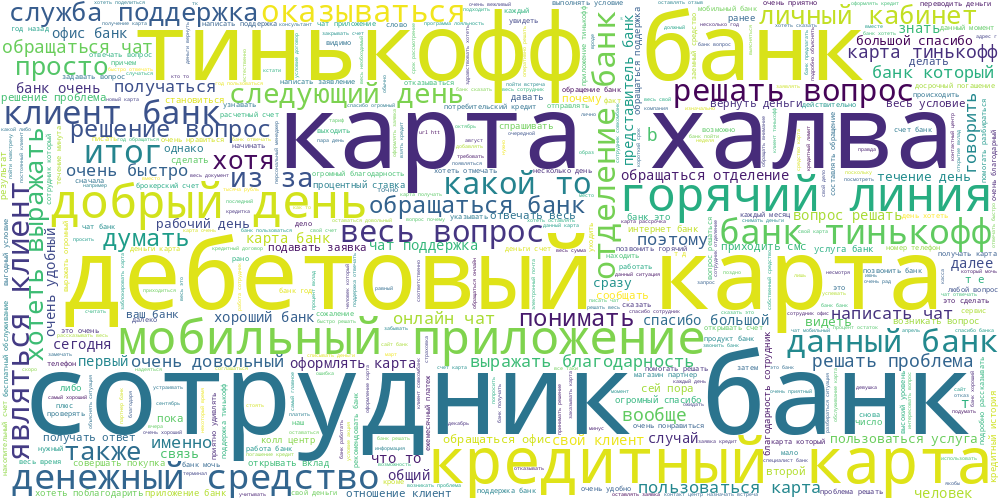

In [47]:
draw_cloud(data_cl[data_cl['bert_clusters'] == 0]['description'])

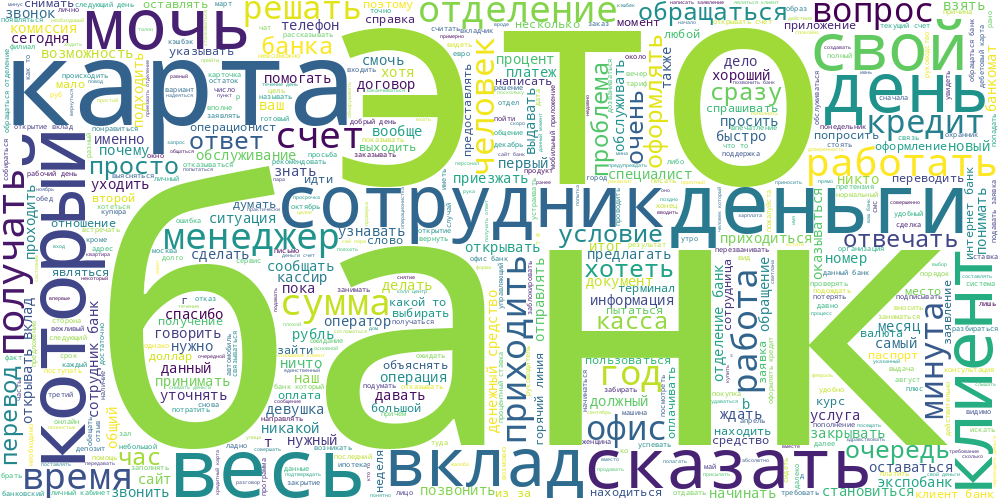

In [45]:
draw_cloud(data_cl[data_cl['bert_clusters'] == 1]['description'])

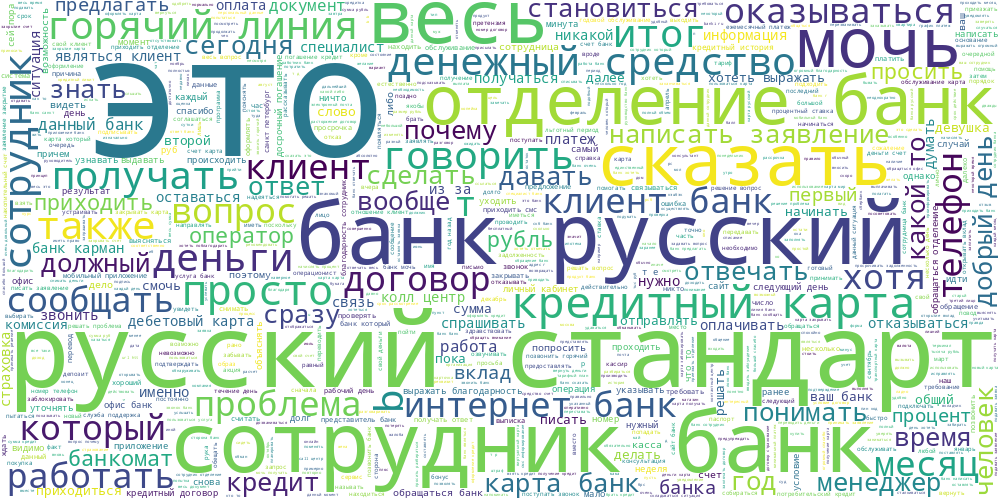

In [48]:
draw_cloud(data_cl[data_cl['bert_clusters'] == 2]['description'])

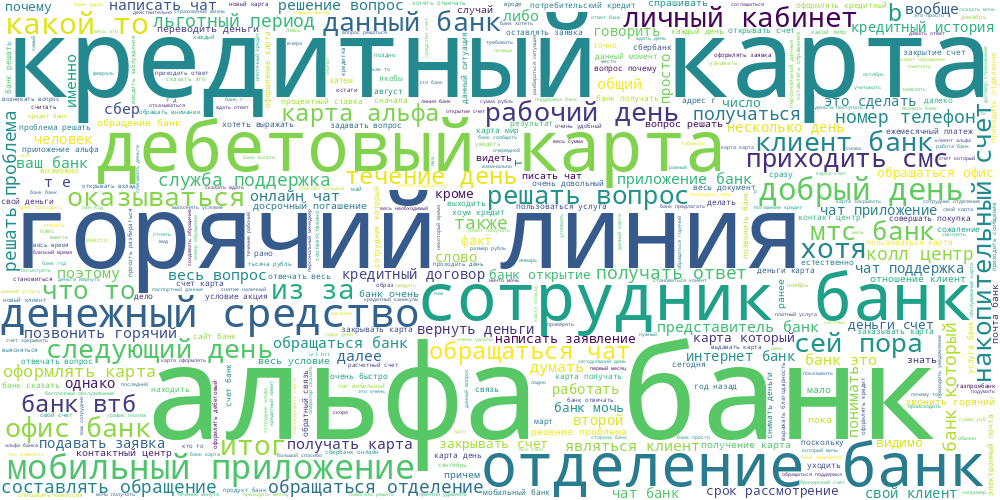

In [49]:
draw_cloud(data_cl[data_cl['bert_clusters'] == 3]['description'])

### Визуализация

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate='auto', init='random')
d2_feat = tsne.fit_transform(bank_vectors)

In [56]:
clusster_data['TSNE_0'] = d2_feat[:,0]
clusster_data['TSNE_1'] = d2_feat[:,1]

Text(0.5, 1.0, 'Spectr')

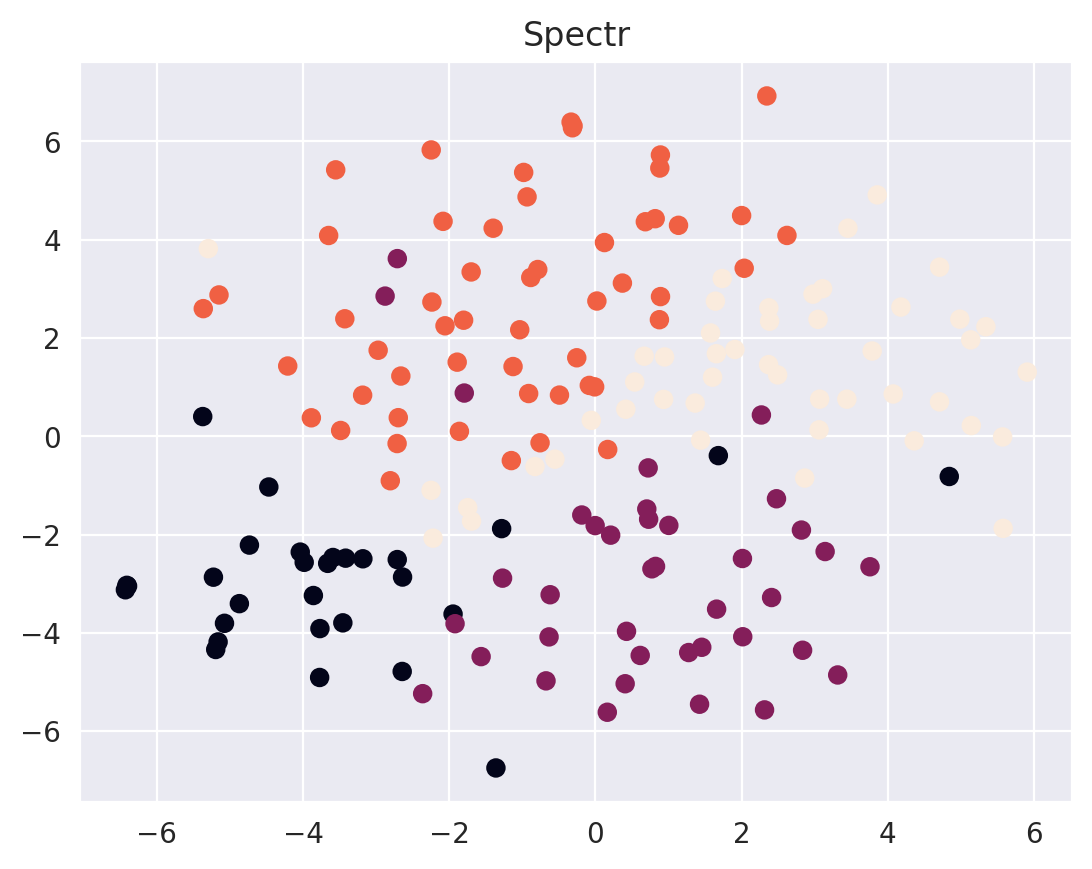

In [62]:
plt.scatter(clusster_data['TSNE_0'], clusster_data['TSNE_1'], c=clusster_data['bert_clusters'])
plt.title('Spectr')

In [72]:
np.mean(comments_raw_data[comments_raw_data['bank'].isin(cl0)]['rating'])

3.7851331186798816

In [74]:
np.mean(comments_raw_data[comments_raw_data['bank'].isin(cl1)]['rating'])

2.7213397435897435

In [75]:
np.mean(comments_raw_data[comments_raw_data['bank'].isin(cl2)]['rating'])

2.706682690614545

In [76]:
np.mean(comments_raw_data[comments_raw_data['bank'].isin(cl3)]['rating'])

2.5286386658632316